In [77]:
import collections as co
import pandas as pd
import numpy as np
import seaborn as sns
import re
from ete3 import PhyloTree, Tree, faces, AttrFace, CircleFace, TreeStyle, NodeStyle, TextFace, RectFace, SequenceFace
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize
import math
from matplotlib import colors
from natsort import natsorted
from Bio import SeqIO
from Bio.Seq import Seq
import scipy.spatial.distance as ssd
import random

In [78]:
import os
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

In [79]:
def getNewick(node, newick, parentdist, leaf_names):
    
    if node.is_leaf():
        return(leaf_names[node.id] + ":" + np.format_float_positional(parentdist - node.dist) + newick)
        #return "%s:%.5f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    
    else:
        if len(newick) > 0:
            newick = "):" + np.format_float_positional(parentdist - node.dist) + newick
            #newick = "):%.5f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), "," + newick, node.dist, leaf_names)
        #newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        
        newick = "(" + newick
        #newick = "(%s" % (newick)
        return(newick)

In [80]:
def getVector(frame, components, col):

    duplicate = components.copy()
    duplicate.update(frame[col].value_counts().to_dict())
    
    vector = pd.DataFrame([duplicate.values()])
    duplicate.clear()
    
    return(vector)

In [81]:
def getTree(framelink, treequery, feature = 'hostsel', rownumber = 2, prune = True, treshold = 0.5, listcolor = []):
    
    treelabel = treequery.index.values
    treestyle = TreeStyle()
    treelink = framelink.drop(columns=['parent']).to_numpy()
    treehierarchy = hierarchy.to_tree(treelink, False)
    treenewick = getNewick(treehierarchy, "", treehierarchy.dist, treelabel)
    treedict = treequery[['cluster', feature]].to_dict()
    
    listfeature = natsorted(list(set(treedict[feature].values())))

    treecomponents = dict.fromkeys(listfeature, 0)
    featurevectors = treequery[['cluster', feature]].groupby(by=['cluster']).apply(lambda x: getVector(x, treecomponents, feature))
    featurevectors.reset_index(level = 1, drop = True, inplace=True)

    listcluster = featurevectors.index.tolist()
    featurel1vectors = normalize(featurevectors.to_numpy(), norm='l1')
    framefeature = pd.DataFrame(featurel1vectors, index = listcluster, columns = listfeature)

    tree = Tree(treenewick)
    
    if treshold != 0.0:
        listfeature.append('mixed')
    
    if not listcolor or len(listfeature) > len(listcolor):
        listcolor = ["#%06X" % random.randint(0, 0xFFFFFF) for f in listfeature]
    
    dictcolor = dict(zip(listfeature, listcolor[0:len(listfeature)]))
    prunecluster = []
    
    for node in tree.traverse():
        node.img_style["vt_line_width"] = 1
        node.img_style["hz_line_width"] = 1
        node.img_style["vt_line_type"] = 0
        node.img_style["hz_line_type"] = 0
        node.img_style["fgcolor"] = "#000000"
        node.img_style["shape"] = "circle"
        node.img_style["vt_line_color"] = "#000000"
        node.img_style["hz_line_color"] = "#000000"
        node.img_style['bgcolor'] = 'lightgrey'
    
    for leaf in tree.iter_leaves():
        leaf.feature = treedict[feature].get(leaf.name, "none")
        leaf.cluster = treedict['cluster'].get(leaf.name, "none")
    
    if -1 in listcluster:
        listcluster.remove(-1)
    
    for cluster in listcluster:
        listmember = tree.search_nodes(cluster=cluster)
        nodecluster = tree.get_common_ancestor(listmember)
        nodecluster.name = f'cluster {cluster}'
        nodecluster.size = len(listmember)
        
        frame = framefeature.loc[cluster].sort_values(axis=0, ascending=False)
        
        if treshold != 0.0:
            nodecluster.feature = (frame.idxmax() if frame.max() >= treshold else 'mixed')
        else:
            nodecluster.feature = frame.idxmax()
        
        nodecluster.add_face(AttrFace("name", fsize=10), 0, position="aligned")
        nodecluster.add_face(AttrFace("size", fsize=10, text_prefix='|', text_suffix='|'), 1, position="aligned") 
        nodecluster.img_style['bgcolor'] = dictcolor[nodecluster.feature]
        
        prunecluster.append(nodecluster.name)    
        
    if prune == True:
        tree.prune(prunecluster)
        
    treestyle =  TreeStyle()
    treestyle.show_leaf_name = False
    treestyle.draw_guiding_lines = True
    treestyle.guiding_lines_color = 'black'
    treestyle.mode = "c"
    treestyle.allow_face_overlap = False

    column = 0
    for i, feature in enumerate(listfeature, 1): 
        legendcolor = RectFace(width = 20, height = 20, fgcolor = "#000000", bgcolor = dictcolor[feature], label = None)
        treestyle.legend.add_face(legendcolor, column = column)
        legendtext = TextFace(feature)
        legendtext.margin_right = 5
        legendtext.margin_left = 1
        treestyle.legend.add_face(legendtext, column = column + 1)

        if i%rownumber == 0:
            column = column + 2

    treestyle.legend_position = 1
        
    return(tree, treestyle)

In [82]:
def splitSubtype(subtype):
    
    if re.match('^[H][0-9]+N[0-9]+$', subtype): 
        H = re.search('[H][0-9]+', subtype).group(0)
        N = re.search('[N][0-9]+', subtype).group(0)
    else:
        H = ''#np.nan
        N = ''#np.nan
    return(H, N)

In [83]:
def fillGaps(frame):
    
    array = frame.unique()
    array = array[array != '']
    if len(array) == 1:
        frame.replace('', array[0], inplace = True)
        frame.fillna(array[0], inplace = True)
    else:
        frame.replace('', 'NA', inplace = True)
        frame.fillna('NA', inplace = True)
        
    return(frame)

In [84]:
def curateFASTA(fasta, split, acc_ident = 0, column_ident = {'':1}):
    
    meta = {ident:{} for ident in column_ident.keys()}
    
    for entry in SeqIO.parse(fasta,'fasta'):
    
        header = entry.description.split(split)

        accession = header[acc_ident] if type(acc_ident) == int else re.search('.*' + acc_ident + '([^|]+).*', entry.description)[1]

        for key in column_ident.keys():

            position = column_ident[key]
            meta[key][accession] = header[position] if type(position) == int else '' if re.search('.*' + position + '([^|]+).*', entry.description) == None else re.search('.*' + position + '([^|]+)|.*', entry.description)[1]    
            
    return(meta)

In [115]:
link = pd.read_csv('linkage.csv', sep = ',', na_filter = False, header = 0)
cluster = pd.read_csv('cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)

In [116]:
meta = curateFASTA('degue.fasta', '|', 0, {'name':1,'segment':2,'year':3,'host':4,'country':5,'subtype':6,'type':7,})

In [117]:
framemeta = pd.DataFrame(meta)

In [118]:
#Virus specific correction

#framemeta[['H', 'N']] = framemeta['subtype'].apply(lambda x: splitSubtype(x)).tolist()
#framemeta['subtype'] = framemeta['subtype'].str[0]
framemeta['type'] = framemeta['type'].str.split('_').str[2]

In [119]:
treequery = cluster.join(framemeta)

In [120]:
treequery['subtype'] = treequery.groupby(by = ['cluster'])['subtype'].apply(lambda x : fillGaps(x))
#treequery['H'] = treequery.groupby(by = ['cluster'])['H'].apply(lambda x : fillGaps(x, 'H'))
#treequery['N'] = treequery.groupby(by = ['cluster'])['N'].apply(lambda x : fillGaps(x, 'N'))

In [121]:
treequery.replace('', 'NA', inplace = True)
treequery.replace(np.nan, 'NA', inplace = True)

In [122]:
tree, ts = getTree(link, treequery, feature = 'type', rownumber = 1, prune = True, treshold = 1.0, listcolor = ['#FF0029','#377EB8','#66A61E','#984EA3','#00D2D5','#FF7F00','#AF8D00','#7F80CD','#B3E900','#C42E60','#A65628','#F781BF','#8DD3C7','#BEBADA','#FB8072','#80B1D3','#FDB462','#FCCDE5','#99A893','#EED5D2','#3F00FF','#DABF86'])

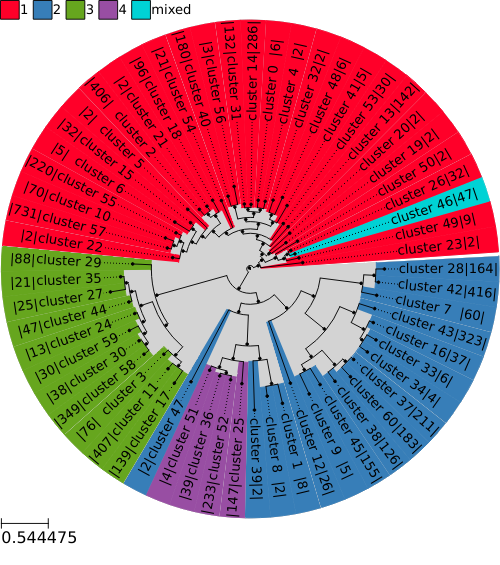

In [124]:
tree.render(file_name = '%%inline', tree_style = ts, w = 500)

# Alignment

In [163]:
from io import StringIO
from Bio import AlignIO
from Bio import SeqIO
from Bio.Align.Applications import MafftCommandline
import functools

In [164]:
acc_list = treequery.query('cluster == 46').index.tolist()

In [165]:
record_dict = SeqIO.index("degue.fasta", "fasta", key_function = lambda entry: entry.split('|')[0])

In [166]:
_ = SeqIO.write(map(lambda accession: record_dict[accession], acc_list), "test.fasta", "fasta")

In [167]:
in_file = "test.fasta"
mafft_cline = MafftCommandline(input = in_file)

In [168]:
stdout, stderr = mafft_cline()
align = AlignIO.read(StringIO(stdout), "fasta")

In [172]:
_ = AlignIO.write(align, "test.msa", "fasta")

## Garbage Place